In [65]:
from mnist import MNIST
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from ipywidgets import interact
from sklearn.metrics import mean_squared_error as mse

In [66]:
def lire_alpha_digit(digits, chars):
    """
    Takes as input alpha_digits and an array 'chars' containing the letters or integers to select from the alpha_digits
    """
    indexes = []
    for chr in chars:
        # check if positive integer
        if (chr.isdigit() and int(chr)<10 and int(chr)>0):
            indexes.append(int(chr))
        # check if letter
        elif(chr.isalpha() and len(chr)==1):
            indexes.append(ord(chr.lower()) - 87)
    return digits[indexes, :]

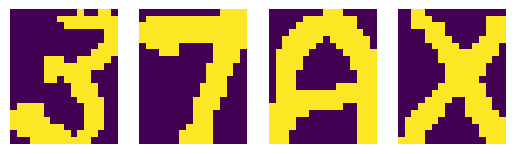

In [67]:
digits = scipy.io.loadmat('binaryalphadigs.mat')['dat']

selected_digits = lire_alpha_digit(digits, ['3', '7', 'A', '-5', 'cb', 'X']) # -5 and 'cb' won't be taken into consideration

fig, axs = plt.subplots(1, selected_digits.shape[0])
for char in range(selected_digits.shape[0]):
    axs[char].axis('off')
    axs[char].imshow(selected_digits[char][7])

A file named 'MNIST' in the same directory should contain the training and testing files extracted, and renamed by replacing the '.' to a '-' <br>
(ex: t10k-images.idx3-ubyte -> t10k-images-idx3-ubyte)

In [68]:
mndata = MNIST('MNIST')
X_train, y_train = mndata.load_training()
X_test, y_test = mndata.load_testing()

X_train = np.array(X_train)
X_train = X_train.reshape(X_train.shape[0], 28, 28)
y_train = np.array(y_train)

X_test = np.array(X_test)
X_test = X_test.reshape(X_test.shape[0], 28, 28)
y_test = np.array(y_test)

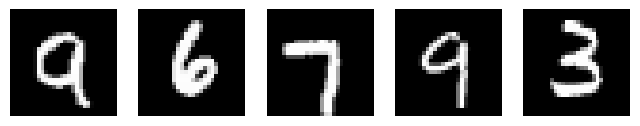

In [69]:
randoms = np.random.randint(0, X_train.shape[0], 5)

fig, axs = plt.subplots(1, randoms.shape[0], figsize=(8,8))
for char, ind in enumerate(randoms):
    axs[char].axis('off')
    axs[char].imshow(X_train[ind], cmap='gray')

In [70]:
def black_white(X, threshold = 125):
    """
    Convert grayscale images of input X to black-and-white images based on given threshold.
    """
    XX = np.empty_like(X)
    XX[X< threshold] = 0
    XX[X>=threshold] = 1
    XX = XX.reshape(*XX.shape, 1) 
    return XX

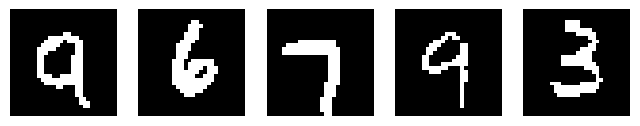

In [71]:
#Testing black_white function
X_train_new = black_white(X_train)

fig, axs = plt.subplots(1, randoms.shape[0], figsize=(8,8))
for char, ind in enumerate(randoms):
    axs[char].axis('off')
    axs[char].imshow(X_train_new[ind], cmap='gray')

In [72]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

class RBM:
    def __init__(self, in_shape, out_shape, W=None, a=None, b=None, var=0.1):
        assert in_shape != 0 and out_shape != 0
        self.in_shape = in_shape
        self.out_shape = out_shape
        
        self.a = a if a is not None else np.zeros(in_shape)
        self.b = b if b is not None else np.zeros(out_shape)
        self.W = W if W is not None else np.random.normal(0, var, (in_shape, out_shape))
        assert self.W.shape == (in_shape, out_shape) and (self.a).shape[0] == in_shape and (self.b).shape[0] == out_shape
        return
    
    def entree_sortie_RBM(self, X_input):
        prod = np.dot(X_input, self.W) + self.b
        assert prod.shape == (X_input.shape[0], self.out_shape), f"prod shape {prod.shape} != (X_input.shape[0], self.out_shape) {(X_input.shape[0], self.out_shape)}"
        sig = sigmoid(prod)
        return sig, np.random.binomial(1, sig, prod.shape)
    
    def sortie_entree_RBM(self, X_output):
        prod = np.dot(X_output, self.W.T) + self.a
        assert prod.shape == (X_output.shape[0], self.in_shape)
        sig = sigmoid(prod)
        return sig, np.random.binomial(1, sig, prod.shape)
    
    def train_RBM(self, X_input, epochs=10, learning_rate=0.01, batch_size=1, vis = False):
        errors = []
        for i in range(epochs):
            for bat in range(0, X_input.shape[0], batch_size):
                v_0 = X_input[bat:min(bat + batch_size, X_input.shape[0])]
                curr_bsize = v_0.shape[0]
                h_0p, h_0d = self.entree_sortie_RBM(v_0)
                v_1p, v_1d = self.sortie_entree_RBM(h_0d)
                h_1p, h_1d = self.entree_sortie_RBM(v_1d)
                self.W = self.W + learning_rate * ((np.tensordot(v_0, h_0p, axes=((0),(0))) - np.tensordot(v_1p, h_1p, axes=((0),(0)))))
                self.a = self.a + learning_rate * (np.sum(v_0 - v_1p, 0))
                self.b = self.b + learning_rate * (np.sum(h_0p - h_1p, 0))
            err = mse(v_0, v_1d)
            errors.append(err)
            if(vis):
                print(f"Epoch {i} mse:{err}")
        return errors
    
    def generer_image_RBM(self, n_iter, n_images, vis=True):
        outputs = []
        for i in range(n_images):
            v_0 = np.random.binomial(1, np.random.rand(1, self.in_shape))
            for iter in range(n_iter):
                h_0p, h_0d = self.entree_sortie_RBM(v_0)
                v_1p, v_1d = self.sortie_entree_RBM(h_0d)
            outputs.append(v_1d.reshape(20, 16))
            if vis:
                plt.figure()
                plt.imshow(outputs[-1], cmap='gray')
                plt.title("Generated image")
                plt.show()
        return np.array(outputs)

            

In [73]:
testing_rbm = RBM(8, 4)
print("RBM shape:", testing_rbm.W.shape)

# Testing entree_sortie_RBM
in_try = np.random.randint(low=0, high=2, size = (6,8))
print("\nInput shape:", in_try.shape)
print("After Entree_sortie:", testing_rbm.entree_sortie_RBM(in_try)[1].shape)

# Testing sortie_entree_RBM
out_try = np.random.randint(low=0, high=255, size = (13,4))
print("\nInput shape to hidden layer:", out_try.shape)
print("After Sortie_Entree", testing_rbm.sortie_entree_RBM(out_try)[1].shape)


RBM shape: (8, 4)

Input shape: (6, 8)
After Entree_sortie: (6, 4)

Input shape to hidden layer: (13, 4)
After Sortie_Entree (13, 8)


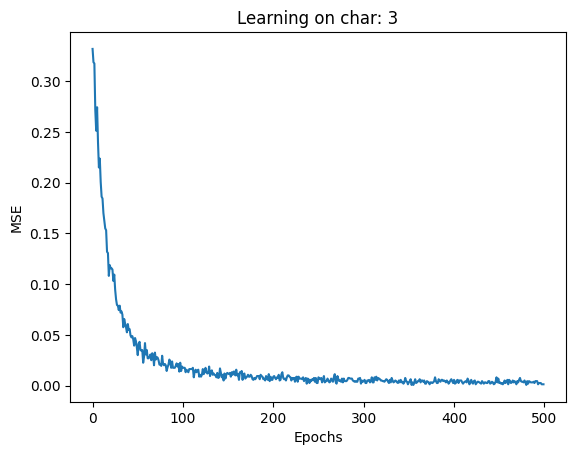

In [74]:
img_RBM = RBM(320, 250) # 320 is the dimension of an (20x16) image flattened

inputs = []
for i in range(35):
    inputs.append(selected_digits[0][i].flatten())
inputs = np.array(inputs)


plt.plot(img_RBM.train_RBM(inputs, 500, 0.01, 6));
plt.title("Learning on char: 3")
plt.xlabel('Epochs');
plt.ylabel('MSE');

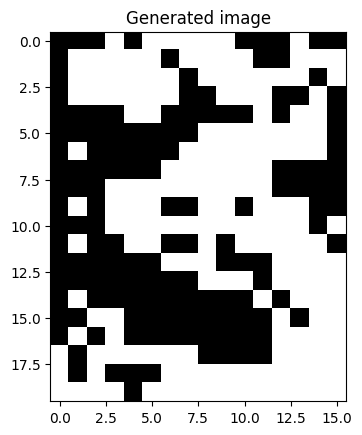

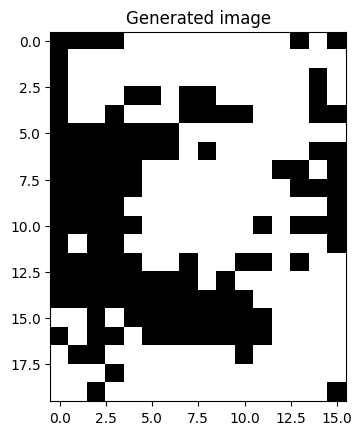

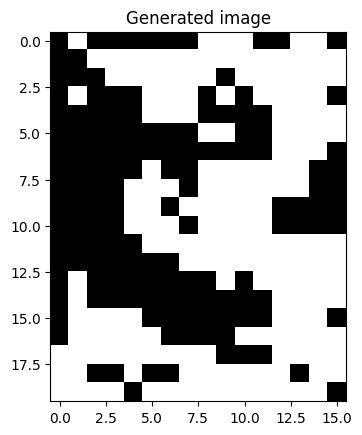

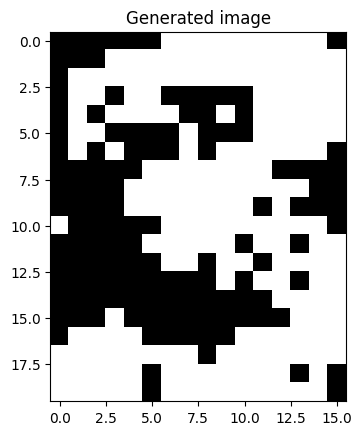

In [75]:
img_RBM.generer_image_RBM(100, 4);